# Overall description
The goal of this project is to come up with a model that's able to mitigate the metal artifact frequently seen in modern MRI images.
Below is a classic metal artifact which impedes the reading of the image.<br>
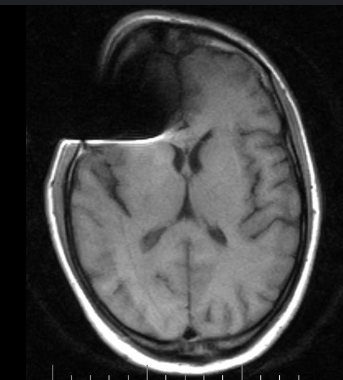


All of the image were downloaded from Stanford MRI image segmentation program/competition.<br>
After downloaded all the images, they were first implemented with metal artifact on the original MRI image, then the preprocessed images were uploaded to google cloud for further use.<br>
The whole training of this U_net were done on google colab A100 GPU.<br>


### Original image<br>

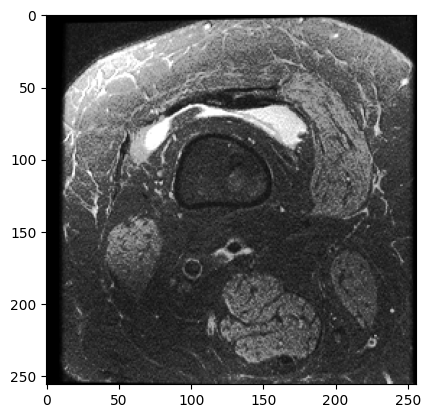

### Processed image(input image/ data image)
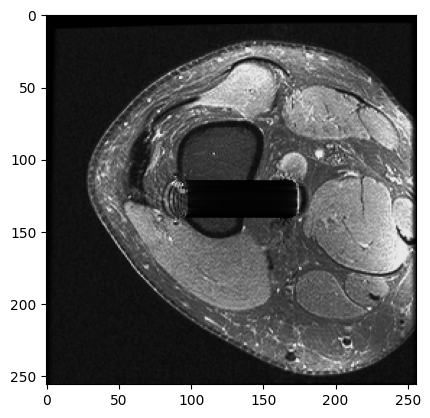

### Denoised image(output image/ label image)
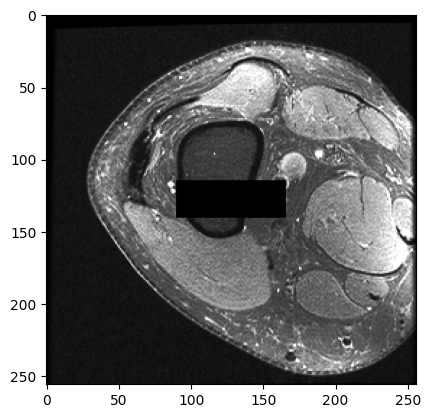

## Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time

## Put images to the same folder
Most of this part of code is done by chatGPT.<br>
The file folder setting is like following:<br>

    |- 0256
    |  |- data_image1
    |  |- data_image2
    |  |- label_image1
    |  |- label_image2
    |    ...
    - 0257
    - 0258

I turned this into:

    - all_data
    |  |- data_image1
    |  |- data_image2
    |  ...
    - all_label
      |- label_image1
      |- label_image2

In [ ]:
# Define your source and destination folders
base_dir = Path("/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256")  # root directory with folders like 0245, 0246...
data_dest = Path("/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/all_data")
label_dest = Path("/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/all_label")

# Create destination folders if they don't exist
data_dest.mkdir(parents=True, exist_ok=True)
label_dest.mkdir(parents=True, exist_ok=True)

# Loop over all subfolders
for subfolder in base_dir.iterdir():
    if subfolder.is_dir():
        for file in subfolder.glob("*.npy"):
            filename = file.name
            new_filename = f"{subfolder.name}_{filename}"

            if filename.startswith("magnitudeFFT"):
                shutil.copy(file, data_dest / new_filename)
            elif filename.startswith("protonDensity"):
                shutil.copy(file, label_dest / new_filename)

print("Files copied and renamed successfully.")

## Pairing my data images and label images
Most of this part of code is done by chatGPT.<br>



In [2]:
def get_paired_npy_files(data_folder: str, label_folder: str) -> list[tuple[Path, Path]]:
    """
    Pair .npy data and label files by matching their full IDs like:
    '0247_magnitudeFFT_slice1.npy' <-> '0247_protonDensity_slice1.npy'
    """
    def get_file_key(path: Path) -> str:
        # Remove suffix, e.g. '.npy'
        stem = path.stem  # e.g., "0247_magnitudeFFT_slice1"
        if 'magnitudeFFT' in stem:
            return stem.replace('magnitudeFFT', '')
        elif 'protonDensity' in stem:
            return stem.replace('protonDensity', '')
        else:
            return None  # not a valid key

    data_folder = Path(data_folder)
    label_folder = Path(label_folder)

    data_files = {get_file_key(f): f for f in data_folder.glob('*.npy') if get_file_key(f)}
    label_files = {get_file_key(f): f for f in label_folder.glob('*.npy') if get_file_key(f)}

    common_keys = sorted(set(data_files.keys()) & set(label_files.keys()))

    paired_files = [(data_files[k], label_files[k]) for k in common_keys]

    return paired_files


In [3]:
train_data_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/all_data"
train_label_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/all_label"

test_data_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/test_folder/data"
test_label_file_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/test_folder/label"

train_paired_files = get_paired_npy_files(train_data_file_path, train_label_file_path)

test_paired_files = get_paired_npy_files(test_data_file_path, test_label_file_path)

In [4]:
class DenoisingDataset(Dataset):
    def __init__(self, paired_files, transform=None):
        self.paired_files = paired_files
        self.transform = transform

    def __len__(self):
        return len(self.paired_files)

    def __getitem__(self, idx):
        noisy_path, clean_path = self.paired_files[idx]
        noisy = np.load(noisy_path).astype(np.float32)  # ensure float32
        clean = np.load(clean_path).astype(np.float32)

        # Normalize to [0,1] if values are in [0,255]
        if noisy.max() > 1.0:
            noisy /= 255.0
        if clean.max() > 1.0:
            clean /= 255.0

        # Add channel dimension: [H, W] -> [1, H, W]
        noisy = torch.from_numpy(noisy).unsqueeze(0)
        clean = torch.from_numpy(clean).unsqueeze(0)

        if self.transform:
            noisy = self.transform(noisy)
            clean = self.transform(clean)

        return noisy, clean


# Visualize dataset

In [12]:
def visualize_dataset(dataset, num_samples=5):
    """
    Visualize a few (data, label) pairs from a given dataset.
    """
    plt.figure(figsize=(10, num_samples * 4))

    for i in range(num_samples):
        data, label = dataset[i]

        # In case the data and label are not 2D (e.g., 1D), you might need to reshape.
        if data.ndim > 2:
            data = data.squeeze()
        if label.ndim > 2:
            label = label.squeeze()

        # Plot data
        plt.subplot(num_samples, 2, 2*i + 1)
        plt.imshow(data, cmap='gray')
        print(data.shape)
        plt.title(f'Data {i+1}')
        plt.axis('off')

        # Plot label
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.imshow(label, cmap='gray')
        print(label.shape)
        plt.title(f'Label {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [13]:
# Create dataset object
train_dataset = DenoisingDataset(train_paired_files)
print(len(train_paired_files))
test_dataset = DenoisingDataset(test_paired_files)
print(len(test_paired_files))

12374
34


train datasets
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


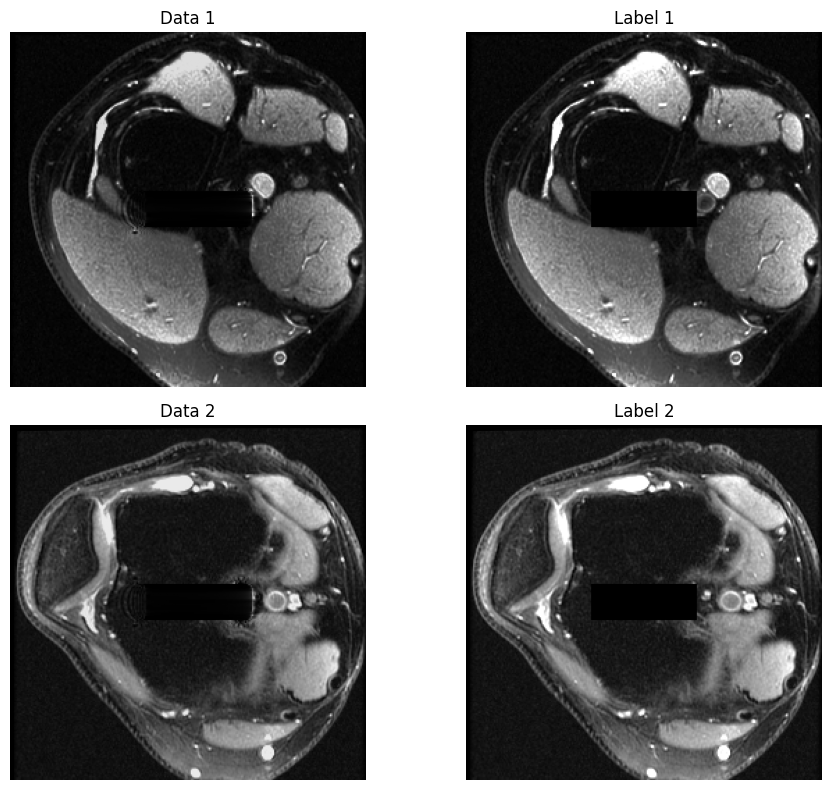

test datasets
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])
torch.Size([256, 256])


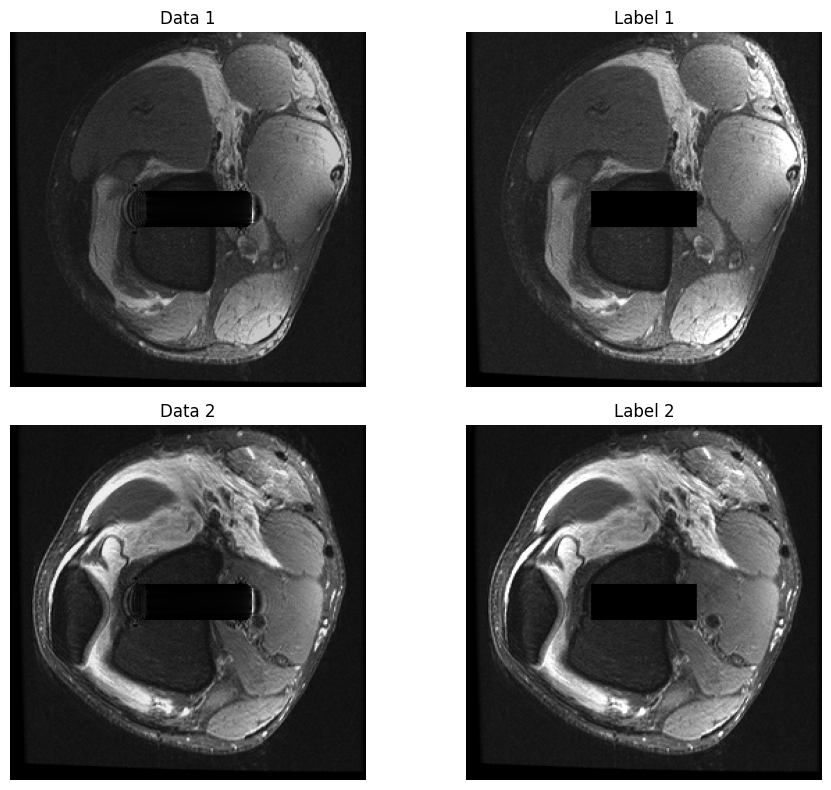

In [14]:
# Visualize 5 pairs
print("train datasets")
visualize_dataset(train_dataset, num_samples=2)
print("test datasets")
visualize_dataset(test_dataset, num_samples=2)

## Creating a customized U-net
Estimated total parameter:

reference: https://youtu.be/u1loyDCoGbE?si=O9JjIz_MNFFeOebT

In [5]:
def double_conv(in_c, out_c):
    model = [
        nn.Conv2d(in_channels=in_c, out_channels=out_c, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=out_c, out_channels=out_c, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    ]
    return model

def upconv(input_tensor, in_c, out_c):
  model = nn.ConvTranspose2d(in_channels=in_c, out_channels=out_c, kernel_size=2, stride=2)
  return model(input_tensor)

def crop_concate_image(input_tensor, target_tensor):
  diffY = input_tensor.shape[2] - target_tensor.shape[2]
  diffX = input_tensor.shape[3] - target_tensor.shape[3]
  cropY = diffY // 2
  cropX = diffX // 2
  new_input_tensor = input_tensor[:, :, cropY:cropY + target_tensor.shape[2], cropX:cropX + target_tensor.shape[3]]
  output_tensor = torch.cat((new_input_tensor, target_tensor), dim=1)
  return output_tensor

In [6]:
class U_net(nn.Module):
  def __init__(self):
    super().__init__()
    self.down_net1 = nn.Sequential(*double_conv(1, 64))
    self.down_net2 = nn.Sequential(*double_conv(64, 128))
    self.down_net3 = nn.Sequential(*double_conv(128, 256))
    self.down_net4 = nn.Sequential(*double_conv(256, 512))
    self.down_net5 = nn.Sequential(*double_conv(512, 1024))

    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
    self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
    self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
    self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
    self.upconv5 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)

    self.up_net1 = nn.Sequential(*double_conv(1024, 512))
    self.up_net2 = nn.Sequential(*double_conv(512, 256))
    self.up_net3 = nn.Sequential(*double_conv(256, 128))
    self.up_net4 = nn.Sequential(*double_conv(128, 64))
    self.up_net5 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1)

  def forward(self, X):
    x1 = self.down_net1(X)
    x2 = self.maxpool(x1)
    x2 = self.down_net2(x2)
    x3 = self.maxpool(x2)
    x3 = self.down_net3(x3)
    x4 = self.maxpool(x3)
    x4 = self.down_net4(x4)
    x5 = self.maxpool(x4)
    x5 = self.down_net5(x5)

    x6 = self.upconv1(x5)
    x6 = crop_concate_image(x4, x6)
    x6 = self.up_net1(x6)

    x7 = self.upconv2(x6)
    x7 = crop_concate_image(x3, x7)
    x7 = self.up_net2(x7)

    x8 = self.upconv3(x7)
    x8 = crop_concate_image(x2, x8)
    x8 = self.up_net3(x8)
    x9 = self.upconv4(x8)
    x9 = crop_concate_image(x1, x9)
    x9 = self.up_net4(x9)
    x10 = self.up_net5(x9)
    return x10

In [7]:
def train_U_net_dataloader(model, train_loader, test_loader,
              epochs=10, lr=1e-4, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for data, label in train_loader:
            # Flatten inputs for fully connected autoencoder
            # data = data.view(data.size(0), -1).to(device)
            # label = label.view(label.size(0), -1).to(device)
            data = data.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = loss_fn(outputs, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, label in test_loader:
                # data = data.view(data.size(0), -1).to(device)
                # label = label.view(label.size(0), -1).to(device)
                data = data.to(device)
                label = label.to(device)
                outputs = model(data)
                loss = loss_fn(outputs, label)
                val_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [15]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [78]:
start_time = time.time()

model = U_net()  # your fully connected autoencoder
train_U_net_dataloader(model, train_loader, test_loader, epochs=4, lr=1e-4)

end_time = time.time()
elapsed_time = end_time-start_time
print(f"Training took {elapsed_time:.2f} seconds.")

Epoch 1/4 | Train Loss: 0.0194 | Val Loss: 0.0037
Epoch 2/4 | Train Loss: 0.0030 | Val Loss: 0.0018
Epoch 3/4 | Train Loss: 0.0019 | Val Loss: 0.0013
Epoch 4/4 | Train Loss: 0.0021 | Val Loss: 0.0018
Training took 20123.86 seconds.


In [79]:
save_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project"
torch.save(model.state_dict(), save_path + "u_net.pt")

# Reload the model
after a overnight trainging

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_save_path = "/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final projectu_net.pt"
loaded_model = U_net()
loaded_model.load_state_dict(torch.load(f=model_save_path))
loaded_model = loaded_model.to(device)

## SSIM Structural similarity (SSIM) index for measuring image quality
Suggested by Professor Farid use to compare the similarity between two pairs:
1. artifact image and the label image
2. model output image and the label image

The diagonal line means they have the same similarty between these 2 pairs(model isn't doing anything).<br>
If under the diagonal line means the model isn't doing good.<br>
And if above the diagonal line means that the model improveed the image quality by denoising the artifact.


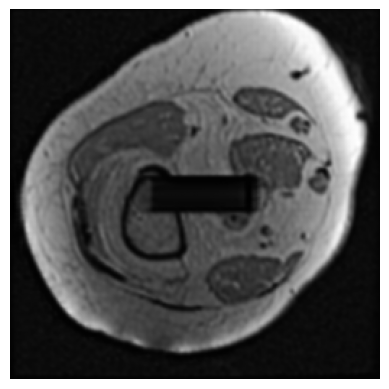

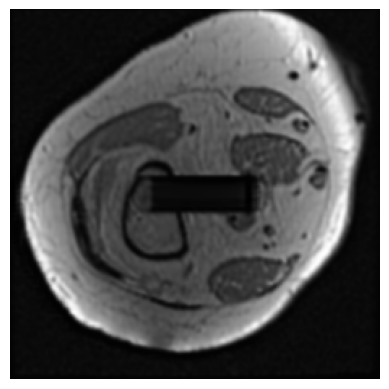

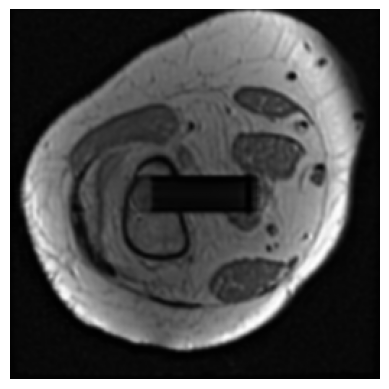

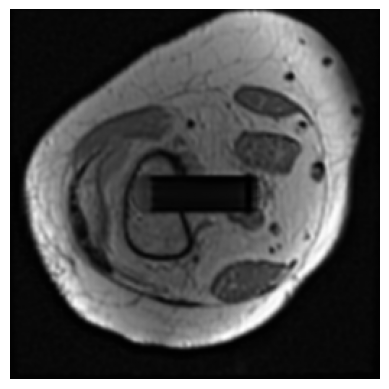

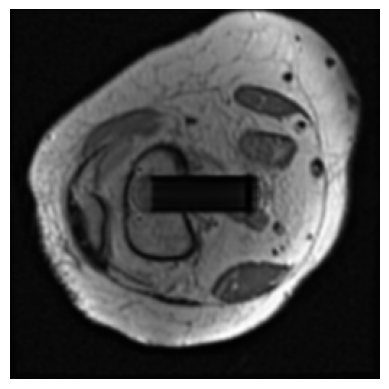

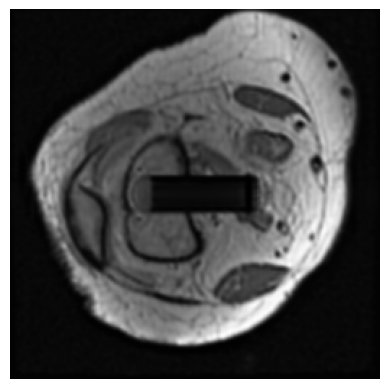

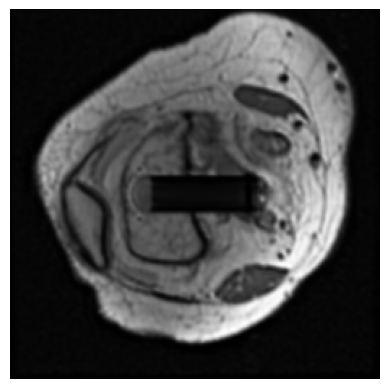

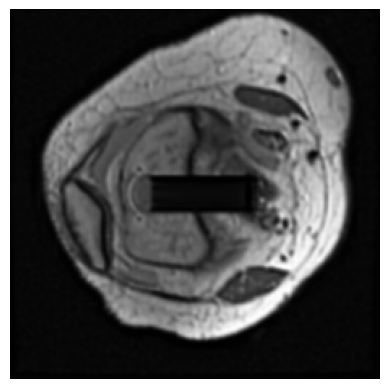

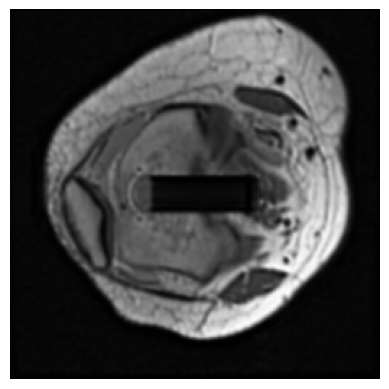

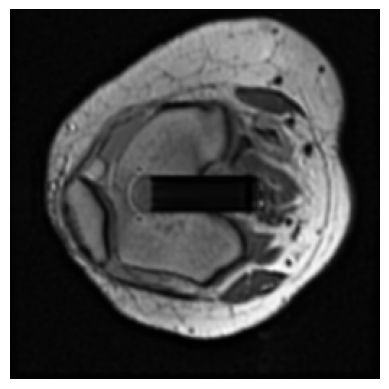

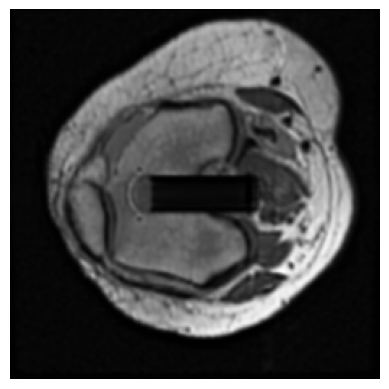

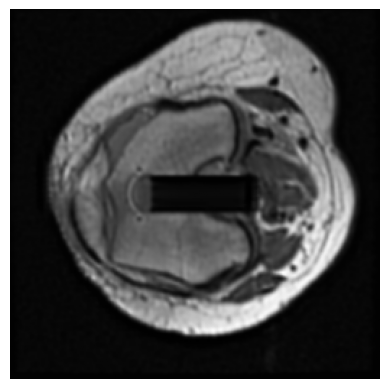

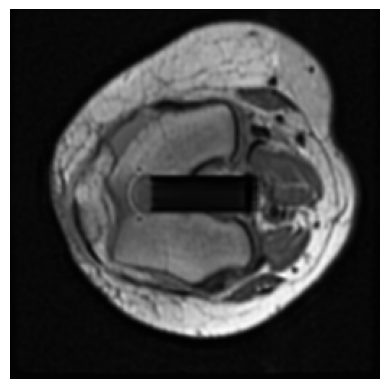

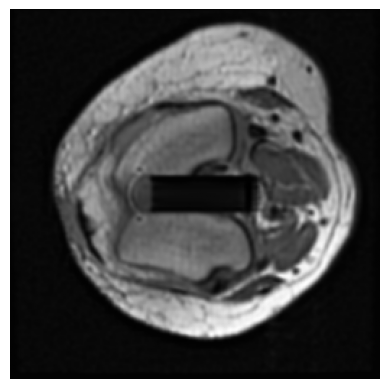

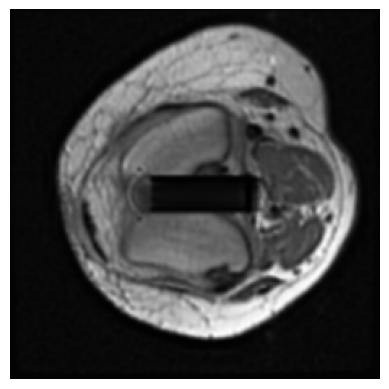

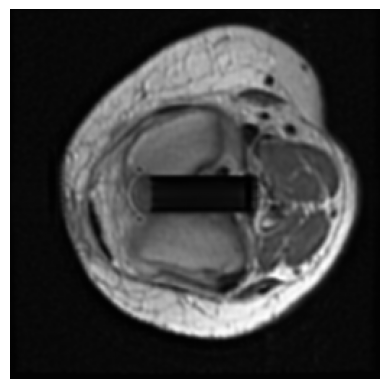

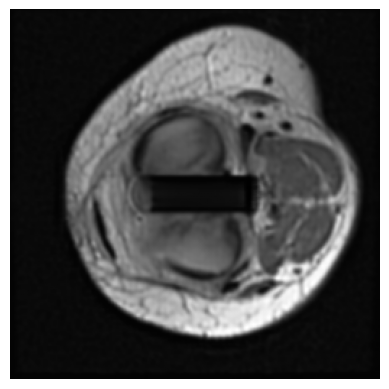

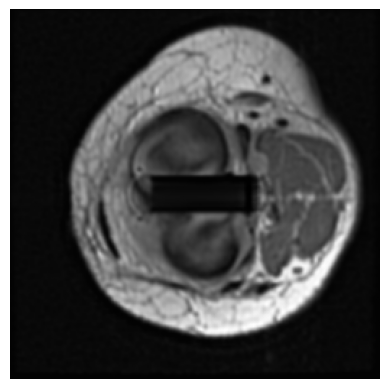

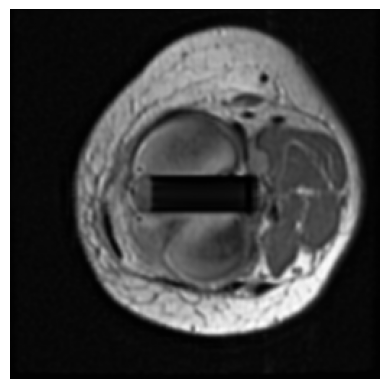

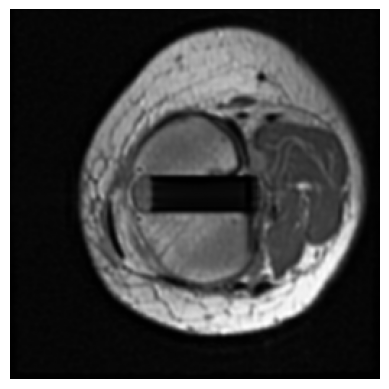

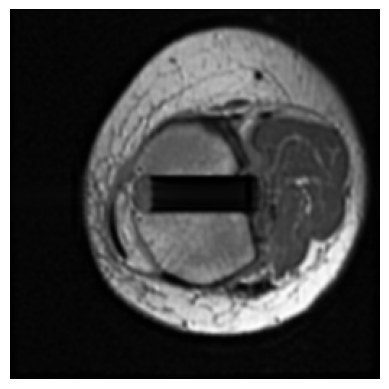

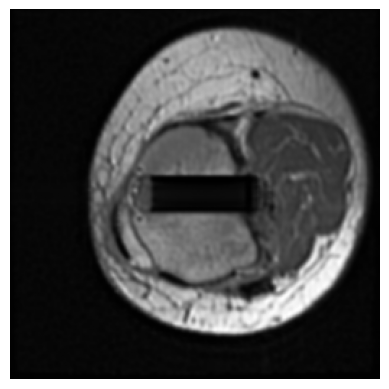

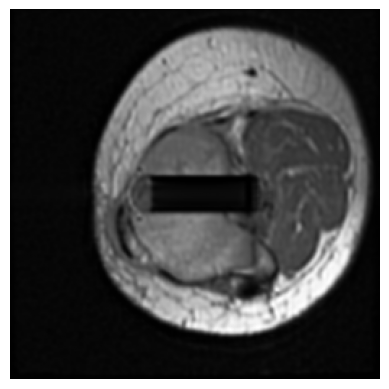

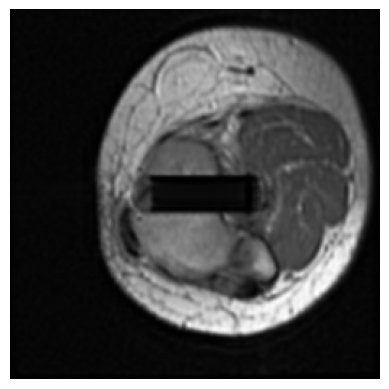

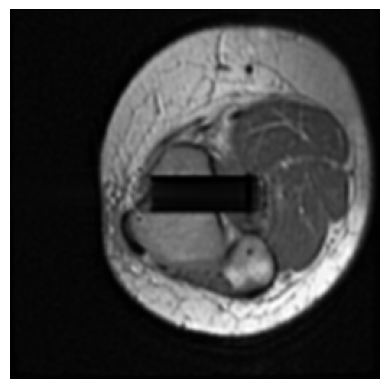

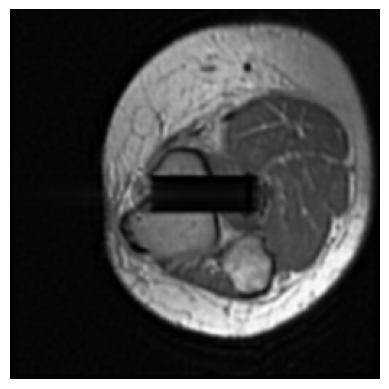

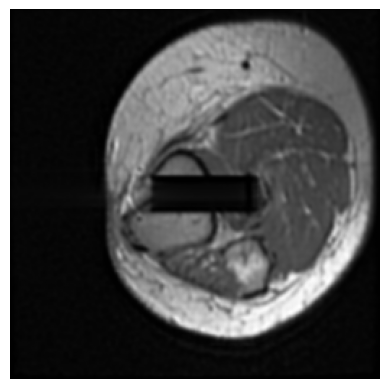

In [26]:
# https://code.adonline.id.au/structural-similarity-index-ssim-in-python/
from skimage.metrics import structural_similarity as ssim

device='cuda' if torch.cuda.is_available() else 'cpu'
test_folder = Path("/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/real_test_folder/data")
label_folder = Path("/content/drive/MyDrive/Berkeley/Spring/Info 290T/Final project/matlab/outputs_try_256/real_test_folder/label")

x_cor = []
y_cor = []

for file in test_folder.iterdir():
  img = np.load(file)
  img_tensor = torch.tensor(img).view(1, 256, 256).unsqueeze(0).to(device)
  output_again = loaded_model(img_tensor)
  img_again = output_again.detach().cpu().numpy().reshape(256, 256)

  # This is the label image
  name = file.name.replace("magnitudeFFT", "protonDensity")
  label_path = label_folder/name
  label_img = np.load(label_path)

  # Collect SSIM x and y coordinate
  x_cor.append(ssim(label_img, img, data_range=label_img.max()-img.min()))
  y_cor.append(ssim(label_img, img_again, data_range=label_img.max()-img_again.min()))

  # VIsualize the output image
  plt.imshow(img_again, cmap='gray') # Use imshow to display the image
  plt.axis(False)
  plt.show()

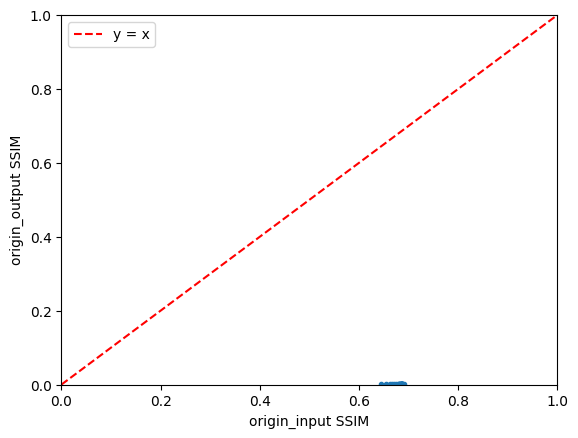

In [27]:
plt.scatter(x_cor,y_cor, marker='.')
plt.plot([0, 1], [0, 1], 'r--', label='y = x')  # Diagonal line in red dashed style
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('origin_input SSIM')
plt.ylabel('origin_output SSIM')
plt.legend()
# plt.grid(True)
plt.show()

## Conslusion
Apparently the model isn't making any progress.
Further thoughts are:
1. Add l1/l2 penalty to the MSE.
2. According to Professor's suggestion that data should at least 100x times the trainable parameter, I should increase my dataset to 31,038,817*100 which is nearly 3 billion images.
3. Another question to be further discussed is that even though the overall output image quality seems better in the U_net then autoencoder, the SSIM is much higher in Autoencoder